In [1]:
%load_ext lab_black
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from admix.data import quantile_normalize
import seaborn as sns

In [11]:
SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp_tables.xlsx?dl=1"
trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="trait-info")
trait_list = trait_info["trait"].values

dict_trait_name = {
    row["trait"]: row["display-name"] for _, row in trait_info.iterrows()
}

In [14]:
df_assoc = []
for trait in trait_list:
    df_assoc.append(pd.read_csv(f"out/locus_hetero/{trait}.csv", index_col=0))
df_assoc = pd.concat(df_assoc).sort_values(["trait_id", "CHR_ID", "CHR_POS"]).dropna()
df_assoc = df_assoc[(df_assoc.EUR_af > 0.005) & (df_assoc.AFR_af > 0.005)].reset_index(
    drop=True
)
df_assoc.loc[:, "expected_HET_pval"] = stats.norm.sf(
    quantile_normalize(-df_assoc.HET_pval)
)
df_assoc.loc[:, "bonferroni_significant"] = df_assoc["HET_pval"] < 0.05 / len(df_assoc)

df_assoc["hue"] = ""
df_assoc.loc[df_assoc.bonferroni_significant, "hue"] = df_assoc.loc[
    df_assoc.bonferroni_significant, "trait_id"
]
df_assoc.loc[~df_assoc.bonferroni_significant, "hue"] = "non-sig"

df_assoc["hue"] = df_assoc["hue"].apply(
    lambda x: dict_trait_name[x] if x in dict_trait_name else x
)
# df_assoc = df_assoc[df_assoc["assoc_pval"] < 1e-5]

In [17]:
from scipy import stats

Text(0, 0.5, '$\\beta_{AFR}$')

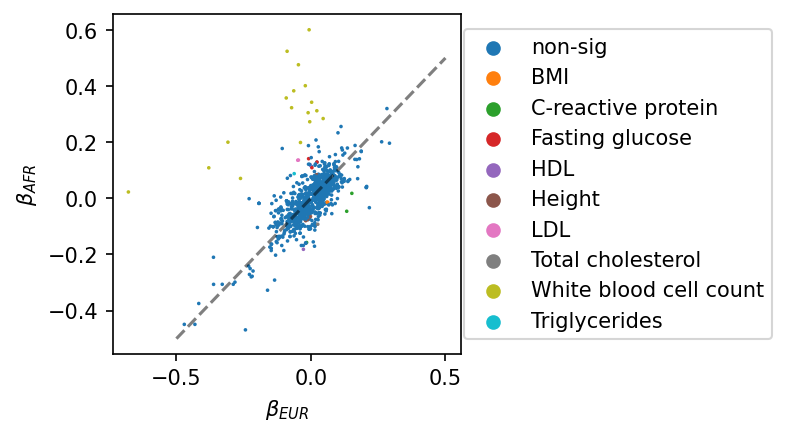

In [20]:
fig, ax = plt.subplots(dpi=150, figsize=(3, 3))
sns.scatterplot(
    data=df_assoc, x="EUR_beta", y="AFR_beta", hue="hue", linewidth=0, s=3, ax=ax
)
ax.plot([-0.5, 0.5], [-0.5, 0.5], color="black", alpha=0.5, ls="--")
ax.legend(loc="center", bbox_to_anchor=[1.45, 0.5])
ax.set_xlabel("$\\beta_{EUR}$")
ax.set_ylabel("$\\beta_{AFR}$")

In [25]:
pval = df_assoc.HET_pval
chi2 = stats.norm.ppf(pval / 2) ** 2
print(f"lambda_gc = {np.quantile(chi2, 0.5) / stats.chi2.ppf(0.5, 1):.3g}")

lambda_gc = 2.03


Text(0, 0.5, 'HET $-\\log_{10}(p)$')

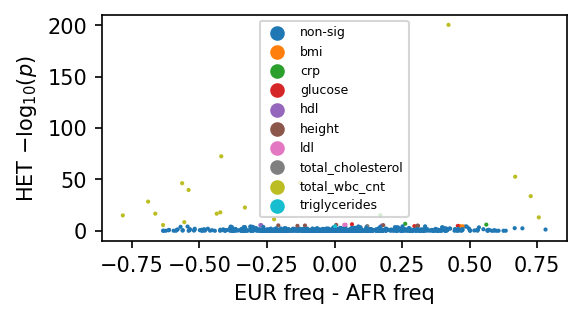

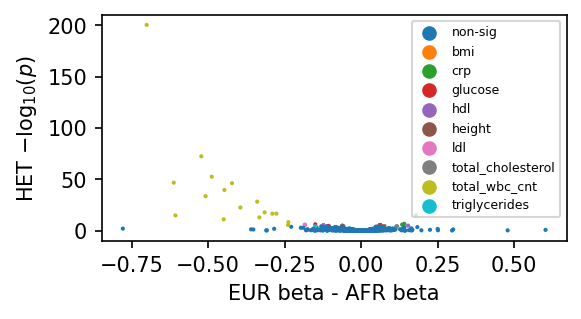

In [26]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
sns.scatterplot(
    x=df_assoc.EUR_af - df_assoc.AFR_af,
    y=-np.log10(df_assoc.HET_pval),
    hue=df_assoc.hue,
    s=4,
    linewidth=0,
    palette="tab10",
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best", fontsize=6)

ax.set_xlabel("EUR freq - AFR freq")
ax.set_ylabel("HET $-\log_{10}(p)$")

fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
sns.scatterplot(
    x=df_assoc.EUR_beta - df_assoc.AFR_beta,
    y=-np.log10(df_assoc.HET_pval),
    hue=df_assoc.hue,
    s=4,
    linewidth=0,
    palette="tab10",
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best", fontsize=6)

ax.set_xlabel("EUR beta - AFR beta")
ax.set_ylabel("HET $-\log_{10}(p)$")

In [27]:
def qqplot(pval, ax=None):
    if ax is None:
        ax = plt.gca()
    expected_pval = stats.norm.sf(quantile_normalize(-pval))
    ax.scatter(-np.log10(expected_pval), -np.log10(pval), s=2)
    lim = max(-np.log10(expected_pval))
    ax.plot([0, lim], [0, lim], "r--")
    ax.set_xlabel("Expected -$\log_{10}(p)$")
    ax.set_ylabel("Observed -$\log_{10}(p)$")

In [28]:
# color points by trait after Bonferroni correction
df_plot = df_assoc[["trait_id", "SNPS", "HET_pval", "assoc_pval"]].copy()
df_plot.loc[:, "expected_HET_pval"] = stats.norm.sf(
    quantile_normalize(-df_plot.HET_pval)
)
df_plot.loc[:, "bonferroni_significant"] = df_plot["HET_pval"] < 0.05 / len(df_plot)

df_plot["hue"] = ""
df_plot.loc[df_plot.bonferroni_significant, "hue"] = df_plot.loc[
    df_plot.bonferroni_significant, "trait_id"
]
df_plot.loc[~df_plot.bonferroni_significant, "hue"] = "non-sig"

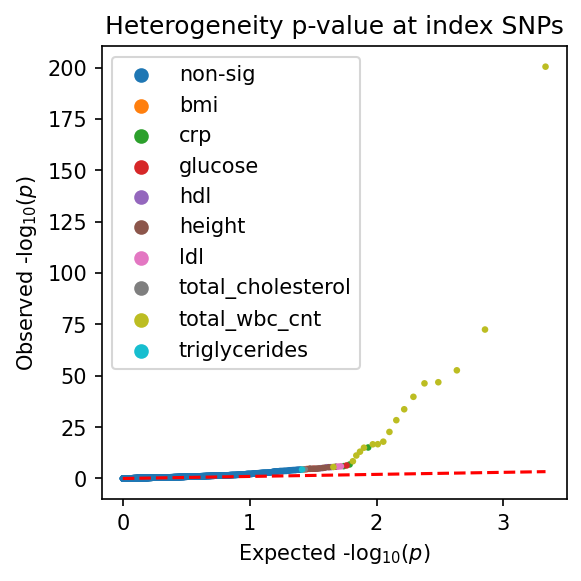

In [29]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
sns.scatterplot(
    x=-np.log10(df_plot.expected_HET_pval),
    y=-np.log10(df_plot.HET_pval),
    hue=df_plot.hue,
    s=10,
    linewidth=0,
    palette="tab10",
    ax=ax,
)
lim = max(-np.log10(df_plot.expected_HET_pval))
ax.plot([0, lim], [0, lim], "r--")
ax.set_xlabel("Expected -$\log_{10}(p)$")
ax.set_ylabel("Observed -$\log_{10}(p)$")
handles, labels = ax.get_legend_handles_labels()
ax.set_title("Heterogeneity p-value at index SNPs")

ax.legend(handles=handles, labels=labels, loc="best")